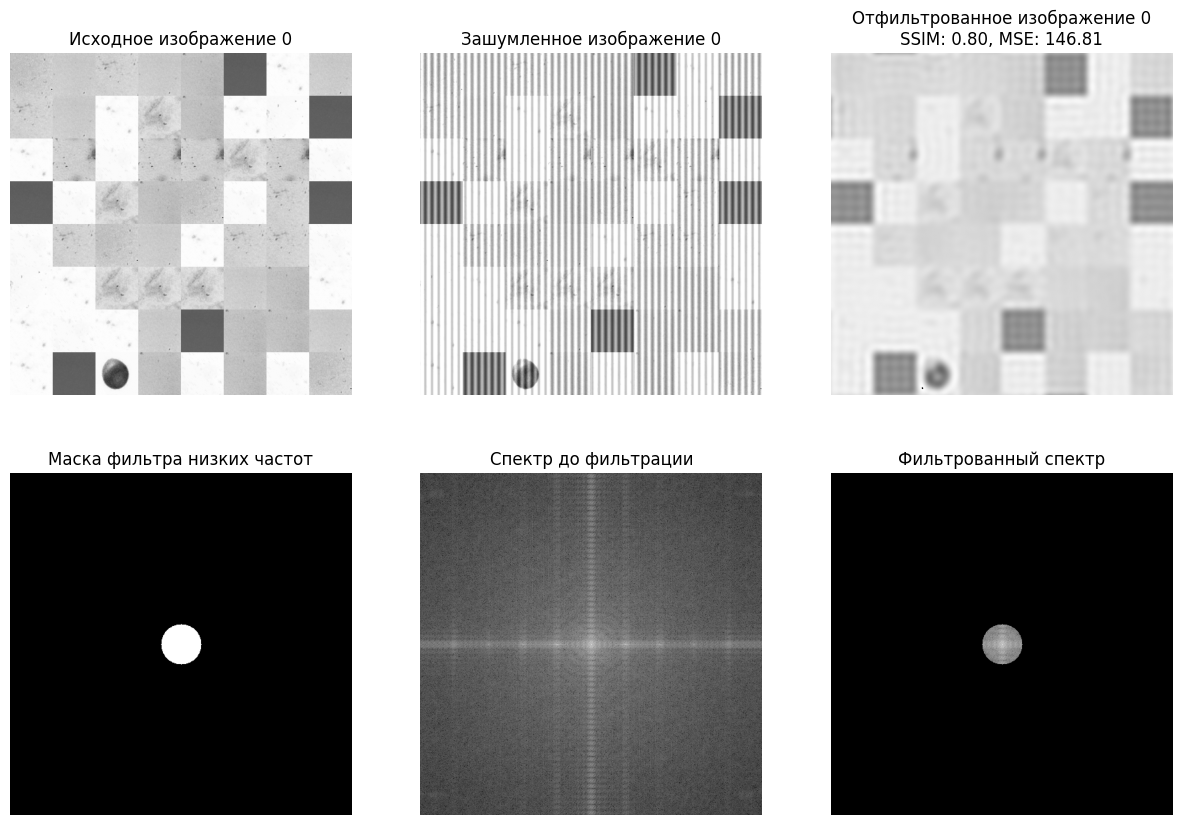

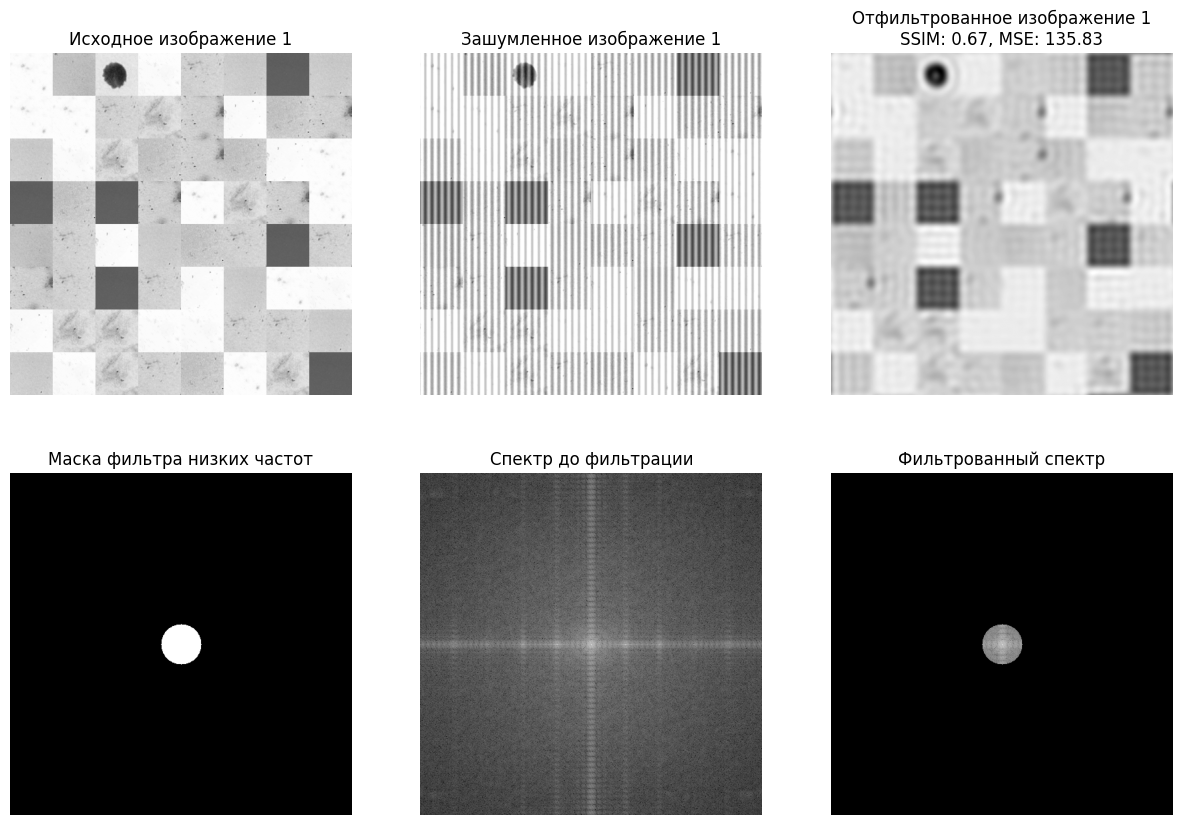

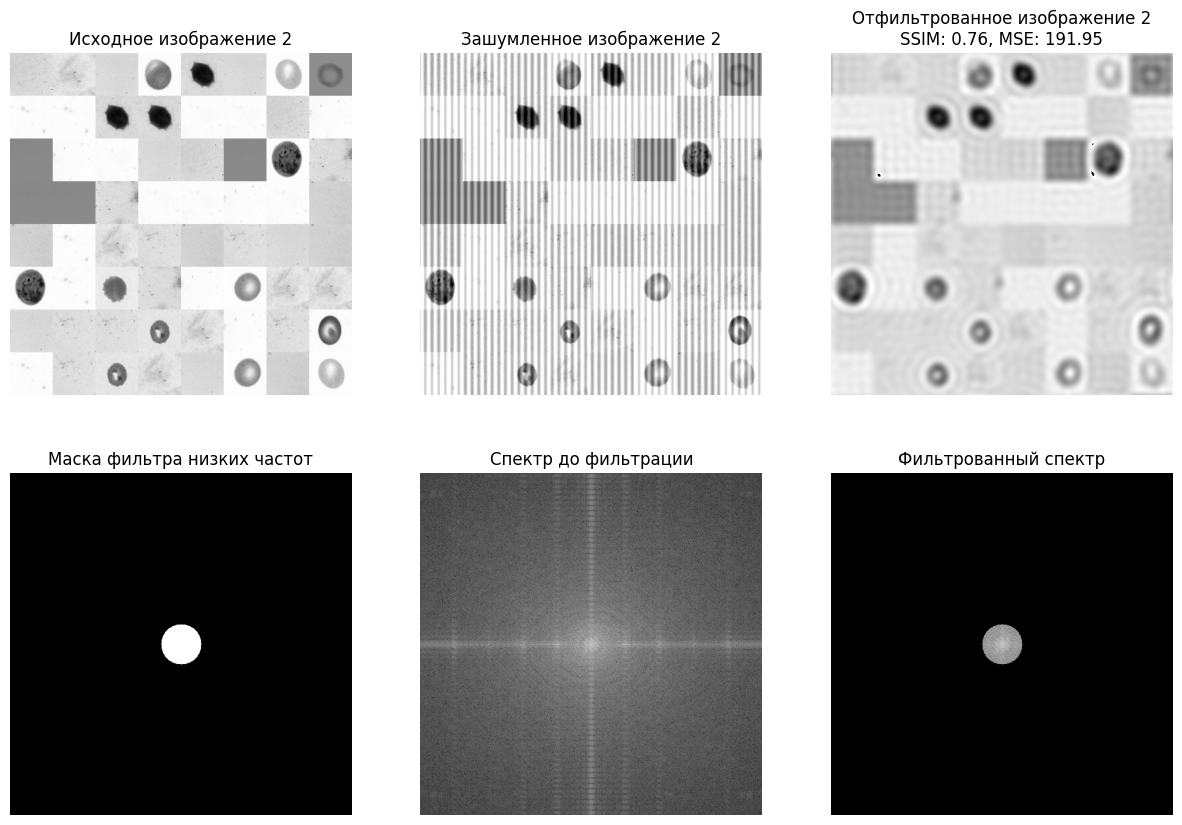

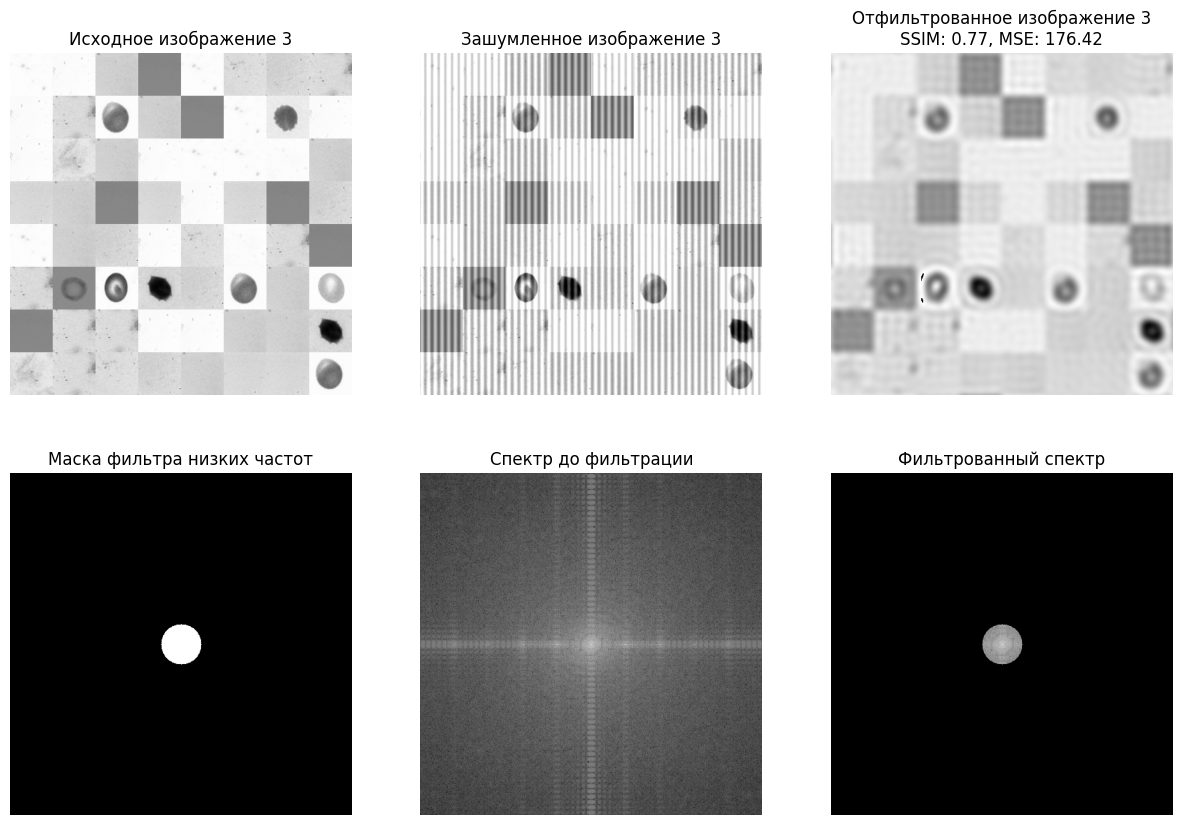

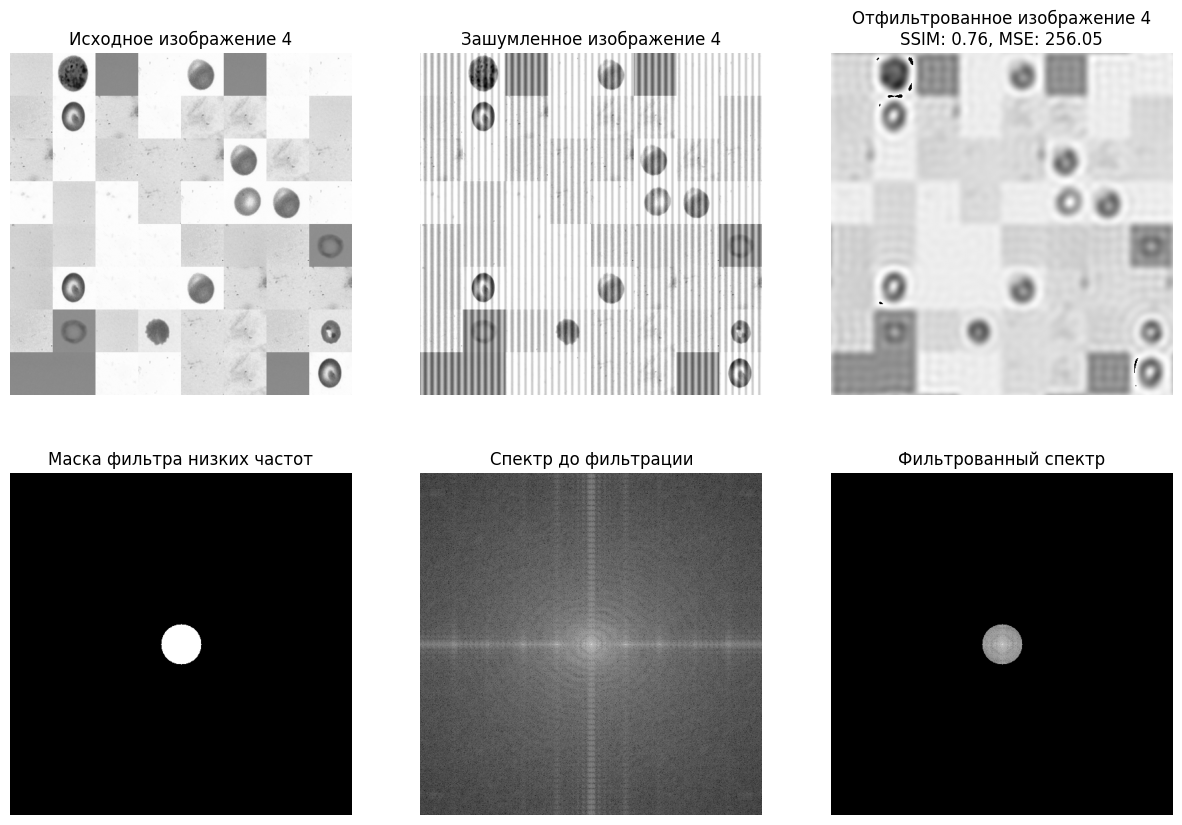

In [ ]:
import os
import random
import numpy as np
import cv2
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import mean_squared_error

# Класс для генерации фона
class BackgroundGenerator:
    def __init__(self, background_dir):
        self.background_images = [os.path.join(background_dir, img) for img in os.listdir(background_dir)]

    def get_random_background_patch(self):
        background_path = random.choice(self.background_images)
        return cv2.imread(background_path, cv2.IMREAD_GRAYSCALE)

# Класс для генерации клеток
class CellGenerator:
    def __init__(self, cell_dir):
        self.cell_images = [os.path.join(cell_dir, img) for img in os.listdir(cell_dir)]

    def get_random_cell_patch(self):
        cell_path = random.choice(self.cell_images)
        return cv2.imread(cell_path, cv2.IMREAD_GRAYSCALE)

# Класс для генерации изображений
class ImageGenerator:
    def __init__(self, background_generator, cell_generator, output_clear_dir, output_noise_dir, output_filtered_dir, image_size=(8, 8)):
        self.background_generator = background_generator
        self.cell_generator = cell_generator
        self.output_clear_dir = output_clear_dir
        self.output_noise_dir = output_noise_dir
        self.output_filtered_dir = output_filtered_dir
        self.image_size = image_size

        # Создание директорий, если они не существуют
        os.makedirs(self.output_clear_dir, exist_ok=True)
        os.makedirs(self.output_noise_dir, exist_ok=True)
        os.makedirs(self.output_filtered_dir, exist_ok=True)

    def generate_image(self):
        patch_size = 64 
        clear_image = np.zeros((patch_size * self.image_size[0], patch_size * self.image_size[1]), dtype=np.uint8)

        num_cells = random.randint(1, 16)
        positions = random.sample(range(self.image_size[0] * self.image_size[1]), num_cells)

        for pos in range(self.image_size[0] * self.image_size[1]):
            x = (pos % self.image_size[1]) * patch_size
            y = (pos // self.image_size[1]) * patch_size
            
            if pos in positions:
                cell_patch = self.cell_generator.get_random_cell_patch()
                cell_patch = cv2.resize(cell_patch, (patch_size, patch_size))
                clear_image[y:y + patch_size, x:x + patch_size] = cell_patch
            else:
                background_patch = self.background_generator.get_random_background_patch()
                background_patch = cv2.resize(background_patch, (patch_size, patch_size))
                clear_image[y:y + patch_size, x:x + patch_size] = background_patch

        return clear_image

    def add_periodic_noise(self, image, frequency=0.1, amplitude=50):
        rows, cols = image.shape
        x = np.arange(cols)
        y = np.arange(rows)
        x, y = np.meshgrid(x, y)
        noise = amplitude * np.sin(2 * np.pi * frequency * x)
        noisy_image = image + noise
        noisy_image = np.clip(noisy_image, 0, 255).astype(np.uint8)
        return noisy_image

    def fourier_transform_filter(self, image):
        # Преобразование Фурье
        f = np.fft.fft2(image)
        fshift = np.fft.fftshift(f)
        
        # Маска фильтра низких частот
        rows, cols = image.shape
        crow, ccol = rows // 2, cols // 2
        mask = np.zeros((rows, cols), np.uint8)
        r = 30  # Радиус круга для маски
        center = (crow, ccol)

        # Создание маски
        cv2.circle(mask, center, r, 1, thickness=-1)

        # Применение маски
        fshift_filtered = fshift * mask
        
        # Обратное преобразование Фурье
        f_ishift = np.fft.ifftshift(fshift_filtered)
        img_filtered = np.fft.ifft2(f_ishift)
        img_filtered = np.abs(img_filtered)
        
        return img_filtered.astype(np.uint8), mask, fshift, fshift_filtered


    def evaluate_filtering(self, original_image, filtered_image):
        ssim_value = ssim(original_image, filtered_image, data_range=filtered_image.max() - filtered_image.min())
        mse_value = mean_squared_error(original_image, filtered_image)
        return ssim_value, mse_value

    def save_and_show_images(self, i):
        # Генерация изображения
        clear_image = self.generate_image()
        # Добавление периодического шума (деградационный шум)
        noisy_image = self.add_periodic_noise(clear_image)
        # Фильтрация с помощью преобразования Фурье
        filtered_image, mask, fshift, fshift_filtered = self.fourier_transform_filter(noisy_image)
        # Оценка качества фильтрации
        ssim_value, mse_value = self.evaluate_filtering(clear_image, filtered_image)

        # Сохранение изображений
        clear_filename = os.path.join(self.output_clear_dir, f'clear_image_{i}.png')
        noise_filename = os.path.join(self.output_noise_dir, f'noisy_image_{i}.png')
        filtered_filename = os.path.join(self.output_filtered_dir, f'filtered_image_{i}.png')

        cv2.imwrite(clear_filename, clear_image)
        cv2.imwrite(noise_filename, noisy_image)
        cv2.imwrite(filtered_filename, filtered_image)

        # Отображение изображений
        plt.figure(figsize=(15, 10))

        # Показ исходного изображения
        plt.subplot(2, 3, 1)
        plt.imshow(clear_image, cmap='gray')
        plt.title(f'Исходное изображение {i}')
        plt.axis('off')

        # Показ зашумленного изображения
        plt.subplot(2, 3, 2)
        plt.imshow(noisy_image, cmap='gray')
        plt.title(f'Зашумленное изображение {i}')
        plt.axis('off')

        # Показ отфильтрованного изображения
        plt.subplot(2, 3, 3)
        plt.imshow(filtered_image, cmap='gray')
        plt.title(f'Отфильтрованное изображение {i}\nSSIM: {ssim_value:.2f}, MSE: {mse_value:.2f}')
        plt.axis('off')

        # Маска низких частот
        plt.subplot(2, 3, 4)
        plt.imshow(mask, cmap='gray')
        plt.title(f'Маска фильтра низких частот')
        plt.axis('off')

        # Показ спектра перед фильтрацией
        plt.subplot(2, 3, 5)
        plt.imshow(np.log(np.abs(fshift) + 1), cmap='gray')
        plt.title(f'Спектр до фильтрации')
        plt.axis('off')

        # Показ фильтрованного спектра
        plt.subplot(2, 3, 6)
        plt.imshow(np.log(np.abs(fshift_filtered) + 1), cmap='gray')
        plt.title(f'Фильтрованный спектр')
        plt.axis('off')

        plt.show()


cells_path = 'blood_cells/cells'
background_path = 'blood_cells/background'
output_clear_dir = 'task3/dataset/clear'
output_noise_dir = 'task3/dataset/noise'
output_filtered_dir = 'task3/dataset/filtered'

os.makedirs(output_clear_dir, exist_ok=True)
os.makedirs(output_noise_dir, exist_ok=True)

background_generator = BackgroundGenerator(background_path)
cell_generator = CellGenerator(cells_path)
image_generator = ImageGenerator(background_generator, cell_generator, output_clear_dir, output_noise_dir, output_filtered_dir)

for i in range(5):
    image_generator.save_and_show_images(i)
